# ***`Text classification with an RNN `***

### Packages & Modules



In [1]:
#Import Packages & Modules

import tensorflow_datasets as tfds
import tensorflow as tf

### Plot Graphs



In [2]:
#A helper function to plot graphs

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

### Dataset



```
The IMDB large movie review dataset is a binary classification dataset—all the reviews have either a positive or negative sentiment.
```



In [4]:
#Download the dataset using TFDS
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteQ83LXK/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteQ83LXK/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteQ83LXK/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [5]:
# The Encoder
encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185




```
This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.
```



In [6]:
sample_string = 'Hi TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [1052, 7961, 6307, 2327, 4043, 2120, 7975]
The original string: "Hi TensorFlow."


In [8]:
assert original_string == sample_string

for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

1052 ----> Hi
7961 ---->  
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


### Prepare the data for training





```
Next create batches of these encoded strings. 
```



In [9]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [10]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

### Create the model



```
Build a tf.keras.Sequential model and start with an embedding layer.
An embedding layer stores one vector per word. 
When called, it converts the sequences of word indices to sequences of vectors. 
These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.
```





```
This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a tf.keras.layers.Dense layer.
```





```
A recurrent neural network (RNN) processes sequence input by iterating through the elements. 
RNNs pass the outputs from one timestep to their input—and then to the next.

The tf.keras.layers.Bidirectional wrapper can also be used with an RNN layer. 
This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.
```



In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

### Compile the model 



In [12]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

### Train the model

In [13]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset,  validation_steps=30)

Epoch 1/10
391/391 [==============================] - 44s 112ms/step - loss: 0.6466 - accuracy: 0.5590 - val_loss: 0.4868 - val_accuracy: 0.7479
Epoch 2/10
391/391 [==============================] - 44s 112ms/step - loss: 0.3480 - accuracy: 0.8515 - val_loss: 0.3675 - val_accuracy: 0.8302
Epoch 3/10
391/391 [==============================] - 43s 110ms/step - loss: 0.2555 - accuracy: 0.8991 - val_loss: 0.3408 - val_accuracy: 0.8708
Epoch 4/10
391/391 [==============================] - 43s 110ms/step - loss: 0.2216 - accuracy: 0.9161 - val_loss: 0.4076 - val_accuracy: 0.8604
Epoch 5/10
391/391 [==============================] - 42s 108ms/step - loss: 0.1849 - accuracy: 0.9332 - val_loss: 0.3469 - val_accuracy: 0.8635
Epoch 6/10
391/391 [==============================] - 42s 108ms/step - loss: 0.1672 - accuracy: 0.9400 - val_loss: 0.3646 - val_accuracy: 0.8609
Epoch 7/10
391/391 [==============================] - 42s 107ms/step - loss: 0.1518 - accuracy: 0.9463 - val_loss: 0.3815 - val_ac

### Evaluate the model

In [14]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 18s 45ms/step - loss: 0.4177 - accuracy: 0.8534
Test Loss: 0.41772207617759705
Test Accuracy: 0.8533599972724915


### Test the model



```
If the prediction is >= 0.5, it is positive else it is negative.
```



In [15]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [17]:
 def sample_predict(sample_pred_text, pad): 
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [18]:
# Predict on a sample text without padding

sample_pred_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.2805597]]


In [19]:
# Predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.4336236]]


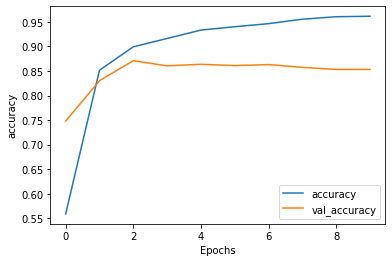

In [20]:
plot_graphs(history, 'accuracy')

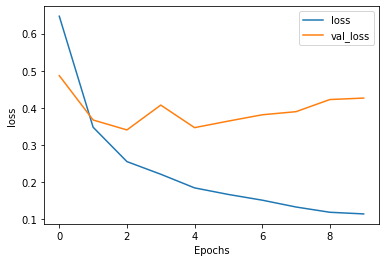

In [21]:
plot_graphs(history, 'loss')

# ***`Stack two or more LSTM layers `***



```
Keras recurrent layers have two available modes that are controlled by the return_sequences constructor argument:

*  Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape (batch_size, timesteps, output_features)).
*  Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).
```



### Construct the model

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

### Compile the model

In [25]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

### Train the model

In [26]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 77s 196ms/step - loss: 0.0827 - accuracy: 0.9788 - val_loss: 0.5631 - val_accuracy: 0.8474
Epoch 2/10
391/391 [==============================] - 76s 194ms/step - loss: 0.0757 - accuracy: 0.9798 - val_loss: 0.5571 - val_accuracy: 0.8573
Epoch 3/10
391/391 [==============================] - 76s 193ms/step - loss: 0.0646 - accuracy: 0.9846 - val_loss: 0.6250 - val_accuracy: 0.8385
Epoch 4/10
391/391 [==============================] - 76s 194ms/step - loss: 0.0559 - accuracy: 0.9874 - val_loss: 0.6341 - val_accuracy: 0.8417
Epoch 5/10
391/391 [==============================] - 77s 196ms/step - loss: 0.0571 - accuracy: 0.9870 - val_loss: 0.6118 - val_accuracy: 0.8464
Epoch 6/10
391/391 [==============================] - 76s 194ms/step - loss: 0.0483 - accuracy: 0.9899 - val_loss: 0.7231 - val_accuracy: 0.8396
Epoch 7/10
391/391 [==============================] - 76s 195ms/step - loss: 0.0532 - accuracy: 0.9866 - val_loss: 0.6440 - val_ac

### Evaluate the model

In [28]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 35s 89ms/step - loss: 0.7301 - accuracy: 0.8406
Test Loss: 0.730070948600769
Test Accuracy: 0.8406000137329102


### Test the model

In [29]:
# Predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-3.8265054]]


In [30]:
# Predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-5.590254]]


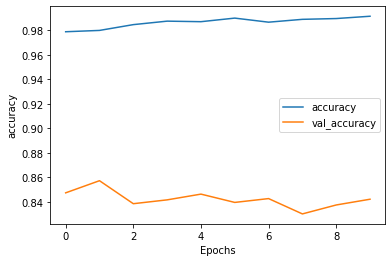

In [31]:
plot_graphs(history, 'accuracy')

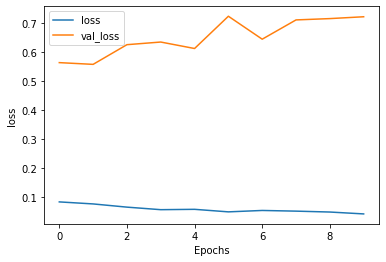

In [32]:
plot_graphs(history, 'loss')